In [1]:
import os

#데이터셋(Oxford - IIIT pet)
##drive에 있는 데이터 꺼내오기

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!tar -xf /content/gdrive/My\ Drive/Colab\ Notebooks/Oxford-IIIT/images.tar.gz

In [4]:
!tar -xf /content/gdrive/My\ Drive/Colab\ Notebooks/Oxford-IIIT/annotations.tar.gz

In [5]:
cur_dir = os.getcwd()
image_dir = os.path.join(cur_dir,'images')
bbox_dir = os.path.join(cur_dir,'annotations','xmls')
seg_dir = os.path.join(cur_dir,'annotations','trimaps')
#경로는 content 바로 아래 풀려있다

In [6]:
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']#확장자가 jpg인거만
print(len(image_files))#7390개

7390


In [7]:
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']#확장자가 xml인거만
print(len(bbox_files))#3686개 (모든 이미지에 대해 bound box가 있는건 아님)

3686


In [8]:
seg_files = [fname for fname in os.listdir(seg_dir) if os.path.splitext(fname)[-1] == '.png' and os.path.splitext(fname)[0][0] != '.']#확장자가 png인거만, os.listdir에서 에러가 계속나서 임시방편
print(len(seg_files))#7390개

7390


In [9]:
len(os.listdir(seg_dir))

14780

In [10]:
seg_dir[:30]

'/content/annotations/trimaps'

##xml file에서 segmentation확인하기

In [11]:
import random
import numpy as np
from PIL import Image
import xml.etree.ElementTree as et #파싱하려고
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

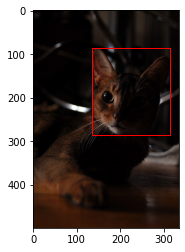

In [13]:
rnd_idx = random.randint(1, len(image_files))
fname = image_files[rnd_idx]
fpath = os.path.join(image_dir,fname)
image = Image.open(fpath)
image = np.array(image)

bbox_name = os.path.splitext(fname)[0] +'.xml'
bbox_path = os.path.join(bbox_dir, bbox_name)
tree = et.parse(bbox_path)

width = float(tree.find('./size/width').text)#xml구조잘 파악하장
height = float(tree.find('./size/height').text)
xmin = float(tree.find('./object/bndbox/xmin').text)
xmax = float(tree.find('./object/bndbox/xmax').text)
ymin = float(tree.find('./object/bndbox/ymin').text)
ymax = float(tree.find('./object/bndbox/ymax').text)

rect_x = xmin
rect_y = ymin
rect_w = xmax - xmin
rect_h = ymax - ymin

rect = Rectangle((rect_x,rect_y),rect_w,rect_h,fill = False, color = 'red')
plt.axes().add_patch(rect)
plt.imshow(image)
plt.show()
#에러나오면 될 때까지 돌려용

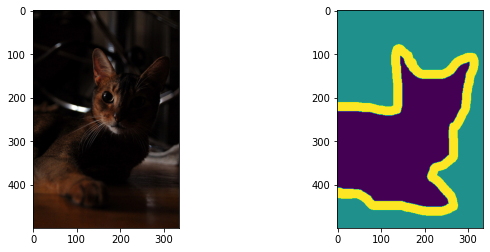

In [14]:
sname = os.path.splitext(fname)[0]+'.png'
spath = os.path.join(seg_dir, sname)
seg = Image.open(spath)
seg = np.array(seg)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(seg)
plt.show()

In [15]:
!nvidia-smi

Mon Aug 17 11:39:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##데이터셋 분할 및 가공



In [16]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import re
from PIL import Image
import shutil
import random
import matplotlib.pyplot as plt

In [17]:
print(tf.__version__)
print(keras.__version__)

2.3.0
2.4.0


In [18]:
#image file중 channel이 3이 아니면 삭제
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    image_mode = image.mode
    if image_mode != 'RGB':
        print(image_file, image_mode)
        image = np.asarray(image)
        print(image.shape)
        os.remove(image_path)
#channel 4개 혹은 흑백이미지 삭제

Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
staffordshire_bull_terrier_22.jpg L
(500, 364)
Egyptian_Mau_14.jpg RGBA
(800, 582, 4)
Egyptian_Mau_177.jpg P
(175, 246)
Egyptian_Mau_145.jpg P
(188, 216)
Abyssinian_5.jpg RGBA
(150, 200, 4)
Egyptian_Mau_167.jpg P
(275, 183)
staffordshire_bull_terrier_2.jpg L
(282, 500)
Egyptian_Mau_191.jpg P
(214, 300)
Egyptian_Mau_129.jpg L
(325, 299)
Abyssinian_34.jpg P
(202, 250)
Egyptian_Mau_139.jpg P
(250, 350)


In [19]:
#이미지 중 channel 3개 아닌거 다삭제하고 갯수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))#7378

7378


In [20]:
#집합으로 이름을 정리
class_list = set()
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+','',file_name)#뒤에 숫자 pug_111같은거에서 삭제
    class_list.add(class_name)
class_list = list(class_list)
print(len(class_list))

37


In [21]:
#정렬
class_list.sort()
class_list

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [22]:
class_list[1]

'Bengal'

In [23]:
class2idx = {cls:idx for idx,cls in enumerate(class_list)}#딕셔너리로 만들어서 one-hot encoding쉽게하자
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [24]:
#train,validation 나누기
train_dir = os.path.join(cur_dir, 'train')
val_dir = os.path.join(cur_dir, 'validation')
os.makedirs(train_dir,exist_ok=True)
os.makedirs(val_dir,exist_ok=True)

In [25]:
image_files.sort()

In [26]:
image_files[:10]

['Abyssinian_1.jpg',
 'Abyssinian_10.jpg',
 'Abyssinian_100.jpg',
 'Abyssinian_101.jpg',
 'Abyssinian_102.jpg',
 'Abyssinian_103.jpg',
 'Abyssinian_104.jpg',
 'Abyssinian_105.jpg',
 'Abyssinian_106.jpg',
 'Abyssinian_107.jpg']

In [27]:
#160번까지는 train_dir로, 그 이상은 val_dir로

cnt = 0
previous_class = ""
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+','',file_name)
    if class_name == previous_class:
        cnt+=1
    else:
        cnt = 1
    if cnt<=160:
        cpath = train_dir
    else:
        cpath = val_dir
    image_path = os.path.join(image_dir, image_file)
    shutil.copy(image_path, cpath)
    previous_class = class_name        

In [28]:
train_images = os.listdir(train_dir)
val_images = os.listdir(val_dir)

In [29]:
print(len(train_images),len(val_images))#나눠줬당.

5920 1458


In [30]:
train_images[:10]

['yorkshire_terrier_178.jpg',
 'Maine_Coon_164.jpg',
 'chihuahua_53.jpg',
 'Birman_136.jpg',
 'Bombay_186.jpg',
 'japanese_chin_43.jpg',
 'havanese_122.jpg',
 'Russian_Blue_43.jpg',
 'german_shorthaired_169.jpg',
 'great_pyrenees_100.jpg']

In [31]:
val_images[:10]

['boxer_95.jpg',
 'Persian_79.jpg',
 'keeshond_7.jpg',
 'havanese_86.jpg',
 'scottish_terrier_92.jpg',
 'american_pit_bull_terrier_9.jpg',
 'Persian_90.jpg',
 'Birman_7.jpg',
 'chihuahua_80.jpg',
 'Birman_63.jpg']

#TFrecord file 만들기


In [32]:
IMG_SIZE = 224

In [33]:
#tfreord저장할곳
#tfrecord file이란 tf를 위한 바이너리 파일 파이프라인 자동 구성됨.
tfr_dir = os.path.join(cur_dir,'tfrecord')
os.makedirs(tfr_dir,exist_ok=True)

tfr_train_dir=os.path.join(tfr_dir,'cls_train.tfr')
tfr_val_dir=os.path.join(tfr_dir,'cls_val.tfr')

In [34]:
#tfrecord writer생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [35]:
#tensorflow 듀토리얼에서 긁어옴.
# https://www.tensorflow.org/tutorials/load_data/tfrecord
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [36]:
#training -> tfrecord
n_train = 0#개수확인용

train_files = os.listdir(train_dir)
for train_file in train_files:
    train_path = os.path.join(train_dir, train_file)
    image = Image.open(train_path)
    image = image.resize((IMG_SIZE,IMG_SIZE))
    bimage = image.tobytes()

    file_name = os.path.splitext(train_file)[0]
    class_name = re.sub('_\d+','',file_name)
    class_num = class2idx[class_name]

    example = tf.train.Example(features=tf.train.Features(feature={
        'image':_bytes_feature(bimage),
        'cls_num':_int64_feature(class_num)
    }))
    writer_train.write(example.SerializeToString())
    n_train += 1

writer_train.close()
print(n_train)

5920


In [37]:
#validation -> tfrecord
n_val = 0#개수확인용

val_files = os.listdir(val_dir)
for val_file in val_files:
    val_path = os.path.join(val_dir, val_file)
    image = Image.open(val_path)
    image = image.resize((IMG_SIZE,IMG_SIZE))
    bimage = image.tobytes()

    file_name = os.path.splitext(val_file)[0]
    class_name = re.sub('_\d+','',file_name)
    class_num = class2idx[class_name]

    example = tf.train.Example(features=tf.train.Features(feature={
        'image':_bytes_feature(bimage),
        'cls_num':_int64_feature(class_num)
    }))
    writer_val.write(example.SerializeToString())
    n_val += 1

writer_val.close()
print(n_val)

1458


In [38]:
!ls -l $tfr_dir

total 1085016
-rw-r--r-- 1 root root 891486880 Aug 17 11:41 cls_train.tfr
-rw-r--r-- 1 root root 219558762 Aug 17 11:41 cls_val.tfr


#Classification

In [39]:
#하이퍼 파라미터
N_CLASS = len(class_list)
N_EPOCHS = 20
N_BATCH = 40
N_TRAIN = n_train
N_VAL = n_val
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN/N_BATCH#1480
validation_steps = int(np.ceil(N_VAL/N_BATCH))#37

In [40]:
#tfrecord를 data로 parsing
def _parse_function(tfrecord_serialized):
    features={'image':tf.io.FixedLenFeature([],tf.string),
              'cls_num':tf.io.FixedLenFeature([],tf.int64)
              }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)#요래 생겼어!! 알려줌

    image = tf.io.decode_raw(parsed_features['image'],tf.uint8)
    image = tf.reshape(image, [IMG_SIZE,IMG_SIZE, 3])
    image = tf.cast(image,tf.float32)/255.0

    label = tf.cast(parsed_features['cls_num'],tf.int64)

    return image,label

In [41]:
#train_dataset
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [42]:
#val_dataset
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls = tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

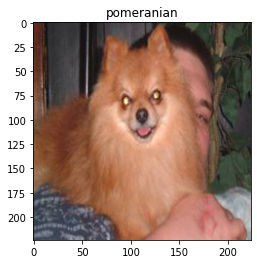

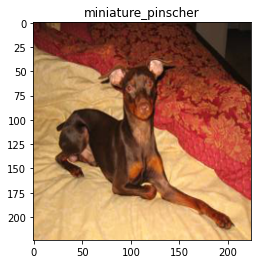

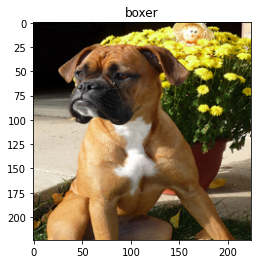

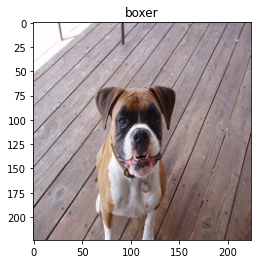

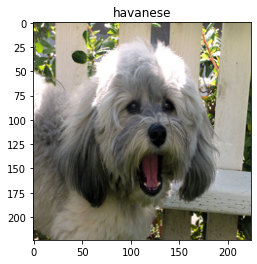

In [43]:
#잘 되었니..?
for image, label in train_dataset.take(5):
    plt.imshow(image[0])#각 배치의 첫번째꺼를 보자
    title = class_list[label[0].numpy()]
    plt.title(title)
    plt.show()

In [44]:
#이번엔 sequential api 사용
def MyModel():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32,3,activation='relu',padding='same',input_shape=(IMG_SIZE,IMG_SIZE,3)))
    model.add(keras.layers.MaxPool2D((2,2),padding='same'))

    model.add(keras.layers.Conv2D(64,3,activation='relu',padding='same'))
    model.add(keras.layers.MaxPool2D((2,2),padding='same'))

    model.add(keras.layers.Conv2D(128,3,activation='relu',padding='same'))
    model.add(keras.layers.MaxPool2D((2,2),padding='same'))

    model.add(keras.layers.Conv2D(256,3,activation='relu',padding='same'))
    model.add(keras.layers.MaxPool2D((2,2),padding='same'))

    model.add(keras.layers.Conv2D(256,3,activation='relu',padding='same'))
    model.add(keras.layers.MaxPool2D((2,2),padding='same'))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024,activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(N_CLASS, activation='softmax'))

    return model

In [45]:
model = MyModel()

model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       2

In [46]:
history = model.fit(
    train_dataset,
    epochs = N_EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_dataset,
    validation_steps = validation_steps
)
#진짜 안된당!!ㅋㅋ

Epoch 1/20
148/148 [==============================] - 13s 88ms/step - loss: 3.5915 - accuracy: 0.0363 - val_loss: 3.4756 - val_accuracy: 0.0761
Epoch 2/20
148/148 [==============================] - 13s 87ms/step - loss: 3.2799 - accuracy: 0.1139 - val_loss: 3.0967 - val_accuracy: 0.1488
Epoch 3/20
148/148 [==============================] - 13s 88ms/step - loss: 3.0004 - accuracy: 0.1740 - val_loss: 2.9519 - val_accuracy: 0.1783
Epoch 4/20
148/148 [==============================] - 13s 90ms/step - loss: 2.8001 - accuracy: 0.2233 - val_loss: 2.8320 - val_accuracy: 0.1914
Epoch 5/20
148/148 [==============================] - 13s 90ms/step - loss: 2.5966 - accuracy: 0.2764 - val_loss: 2.7228 - val_accuracy: 0.2154
Epoch 6/20
148/148 [==============================] - 13s 91ms/step - loss: 2.3624 - accuracy: 0.3319 - val_loss: 2.6798 - val_accuracy: 0.2414
Epoch 7/20
148/148 [==============================] - 13s 91ms/step - loss: 2.0680 - accuracy: 0.4139 - val_loss: 2.6881 - val_accuracy:

In [47]:
#위에거 너무 오바여서 batch norm 넣는다.
def MyModel2():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32,3,padding='same',input_shape=(IMG_SIZE,IMG_SIZE,3)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D((2,2),padding='same'))

    model.add(keras.layers.Conv2D(64,3,padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D((2,2),padding='same'))

    model.add(keras.layers.Conv2D(128,3,padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D((2,2),padding='same'))

    model.add(keras.layers.Conv2D(256,3,padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D((2,2),padding='same'))
    
    model.add(keras.layers.Conv2D(256,3,padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D((2,2),padding='same'))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(N_CLASS, activation='softmax'))

    return model

In [48]:
model = MyModel2()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = learning_rate,
                                                         decay_steps = steps_per_epoch,#epoch마다
                                                         decay_rate = 0.5,
                                                         staircase=True)

model.compile(optimizer=keras.optimizers.Adam(lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
re_lu (ReLU)                 (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 112, 112, 64)     

In [49]:
history = model.fit(
    train_dataset,
    epochs = N_EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_dataset,
    validation_steps = validation_steps
)
#큰 차이는 없당..dropout만 썼을 때 보단 났다.

Epoch 1/20
148/148 [==============================] - 18s 124ms/step - loss: 3.1857 - accuracy: 0.1603 - val_loss: 5.0667 - val_accuracy: 0.0377
Epoch 2/20
148/148 [==============================] - 18s 122ms/step - loss: 1.5766 - accuracy: 0.6187 - val_loss: 5.3265 - val_accuracy: 0.0309
Epoch 3/20
148/148 [==============================] - 18s 122ms/step - loss: 0.8729 - accuracy: 0.8760 - val_loss: 3.7188 - val_accuracy: 0.0947
Epoch 4/20
148/148 [==============================] - 18s 122ms/step - loss: 0.5907 - accuracy: 0.9568 - val_loss: 2.7961 - val_accuracy: 0.2490
Epoch 5/20
148/148 [==============================] - 18s 122ms/step - loss: 0.4846 - accuracy: 0.9743 - val_loss: 2.6533 - val_accuracy: 0.2695
Epoch 6/20
148/148 [==============================] - 18s 122ms/step - loss: 0.4390 - accuracy: 0.9823 - val_loss: 2.6437 - val_accuracy: 0.2743
Epoch 7/20
148/148 [==============================] - 18s 122ms/step - loss: 0.4087 - accuracy: 0.9870 - val_loss: 2.6434 - val_ac

#MobileNetV2 전이학습 할거임. 

###depthwise, pointwise convolution
###inverted residual(narrow->wide->narrow하고 narrow랑 narrow랑 sum)로 skip connection
###linear bottleneck(activation안함)

In [50]:
from tensorflow.keras import models
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D,ReLU,MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [51]:
mobilenetv2 = MobileNetV2(weights = 'imagenet', include_top = False, input_shape=(IMG_SIZE,IMG_SIZE,3))#global average pooling 전까지만!

9412608/9406464 [==============================] - 0s 0us/step


In [52]:
mobilenetv2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [53]:
def MyModel3():
    model = models.Sequential()
    model.add(mobilenetv2)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(N_CLASS,activation='softmax'))
    return model

In [54]:
model = MyModel3()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = learning_rate,
                                                         decay_steps = steps_per_epoch,#epoch마다
                                                         decay_rate = 0.5,
                                                         staircase=True)

model.compile(optimizer=keras.optimizers.Adam(lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 37)                47397     
Total params: 2,305,381
Trainable params: 2,271,269
Non-trainable params: 34,112
_________________________________________________________________


In [55]:
history = model.fit(
    train_dataset,
    epochs = N_EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_dataset,
    validation_steps = validation_steps
)
#전이학습을 해서그런지 많이 좋당! val_accuracy: 0.9218

Epoch 1/20
148/148 [==============================] - 42s 283ms/step - loss: 1.1812 - accuracy: 0.7034 - val_loss: 0.5410 - val_accuracy: 0.8237
Epoch 2/20
148/148 [==============================] - 41s 277ms/step - loss: 0.2374 - accuracy: 0.9446 - val_loss: 0.4679 - val_accuracy: 0.8436
Epoch 3/20
148/148 [==============================] - 41s 279ms/step - loss: 0.1490 - accuracy: 0.9704 - val_loss: 0.4007 - val_accuracy: 0.8676
Epoch 4/20
148/148 [==============================] - 41s 278ms/step - loss: 0.1108 - accuracy: 0.9846 - val_loss: 0.3471 - val_accuracy: 0.8827
Epoch 5/20
148/148 [==============================] - 41s 279ms/step - loss: 0.1007 - accuracy: 0.9853 - val_loss: 0.3192 - val_accuracy: 0.8951
Epoch 6/20
148/148 [==============================] - 42s 282ms/step - loss: 0.0914 - accuracy: 0.9880 - val_loss: 0.2978 - val_accuracy: 0.9026
Epoch 7/20
148/148 [==============================] - 41s 279ms/step - loss: 0.0893 - accuracy: 0.9897 - val_loss: 0.2828 - val_ac

In [56]:
#data augmentation 추가해서 epochs도 늘려준당.(cutmix)
N_EPOCHS = 50

In [57]:
#tfrecord를 data로 parsing
#Cutmix를 할거라서 sparse형식으론 안되고, one hot으로 가야됨
def _parse_function(tfrecord_serialized):
    features={'image':tf.io.FixedLenFeature([],tf.string),
              'cls_num':tf.io.FixedLenFeature([],tf.int64)
              }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)#요래 생겼어!! 알려줌

    image = tf.io.decode_raw(parsed_features['image'],tf.uint8)
    image = tf.reshape(image, [IMG_SIZE,IMG_SIZE, 3])
    image = tf.cast(image,tf.float32)/255.0

    label = tf.cast(parsed_features['cls_num'],tf.int64)
    label = tf.one_hot(label, N_CLASS)
    
    return image,label


In [58]:
#Cutmix
#모든 이미지가 아니라 50%의 이미지만 cutmix를 해주자!!
def cutmix(images, labels, PROB=0.5):  
  imgs = []; labs = []
  for i in range(N_BATCH):#배치단위로 적용할거임
    APPLY = tf.cast(tf.random.uniform(()) <= PROB, tf.int32)#적용할 지 말지
    idx = tf.random.uniform((), 0, N_BATCH, tf.int32)#i번째 이미지에 붙일거는 배치크기안에서 랜덤하게 뽑아서 붙일거임(자기자신도 가능)

    W = IMG_SIZE; H = IMG_SIZE
    lam = tf.random.uniform(())#람다 크기 정할 때 쓴다.
    cut_ratio = tf.math.sqrt(1.-lam)#(1-람다)^(1/2)    
    cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY#어플라이가 0이면 0
    cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY#아니면 1

    cx = tf.random.uniform((), int(W/8), int(7/8*W), tf.int32)#원래 논문이랑 다르당
    cy = tf.random.uniform((), int(H/8), int(7/8*H), tf.int32)#백그라운드에 들어가는게 시렁시렁
    #중심은 랜덤

    xmin = tf.clip_by_value(cx - cut_w//2, 0, W)#clip을 해서 이미지 밖을 지정하는 일이 없게, 0<= <=W
    ymin = tf.clip_by_value(cy - cut_h//2, 0, H)
    xmax = tf.clip_by_value(cx + cut_w//2, 0, W)
    ymax = tf.clip_by_value(cy + cut_h//2, 0, H)    
     


    # ----------------------
    # |        top         |
    # |--------------------|
    # |  m.l | m.m |  m.r  |
    # |--------------------|
    # |       bottom       |
    # |                    |
    # |                    |
    # |                    |
    # ----------------------
    #요롷게 되있다 m.m을 바꿔줄것
    #채널은 항상 전부다
    mid_left = images[i, ymin:ymax, :xmin, :]
    mid_mid = images[idx, ymin:ymax, xmin:xmax, :]#보소 혼자다르네!
    mid_right = images[i, ymin:ymax, xmax:, :]
    middle = tf.concat([mid_left, mid_mid, mid_right], axis=1)#middle부분부터 concat
    top = images[i, :ymin, :, :]
    bottom = images[i, ymax:, :, :]
    new_img = tf.concat([top, middle, bottom], axis=0)#concat해서 합쳐준다.
    imgs.append(new_img)
    
    alpha = tf.cast((cut_w*cut_h)/(W*H), tf.float32)#면적비를 계산, 1-람다 = 알파
    label1 = labels[i]; label2 = labels[idx]
    new_label = ((1-alpha)*label1 + alpha*label2)
    labs.append(new_label)

  new_imgs = tf.reshape(tf.stack(imgs), [-1, IMG_SIZE, IMG_SIZE, 3])#다시 배치크기로 만들어준다.
  new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASS])

  return new_imgs, new_labs

In [59]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH)
train_dataset = train_dataset.map(cutmix).repeat()


In [60]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

In [61]:
#배치를 데이터셋으로 묶고 cutmix
#예시
for image, label in train_dataset.take(1):
  for i in range(N_BATCH):    
    print(label[i].numpy())
    plt.imshow(image[i])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [62]:
def MyModel4():
    model = models.Sequential()
    model.add(mobilenetv2)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    #덴스, 배치 norm ,랠루 추가했다.
    model.add(Dense(N_CLASS, activation='softmax'))
    return model

In [63]:
model = MyModel4()

#cosine learning rate decay 적용시키기
LR_INIT = 0.000001
LR_MAX = 0.0002
LR_MIN = LR_INIT
RAMPUP_EPOCH = 4
EXP_DECAY = 0.9

def lr_schedule_fn(epoch):
  if epoch < RAMPUP_EPOCH:#쭈욱 커지다가
    lr = (LR_MAX - LR_MIN) / RAMPUP_EPOCH * epoch + LR_INIT
  else:#감소시작
    lr = (LR_MAX - LR_MIN) * EXP_DECAY**(epoch - RAMPUP_EPOCH)
  return lr

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule_fn)

model.compile(optimizer=tf.keras.optimizers.Adam(LR_INIT),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),#레이블 스무딩까지 적용했다.ex) [0.1,0.1,0.1,0.9]식의 labels
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               327936    
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_6 (ReLU)               (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 37)                9509      
Total params: 2,596,453
Trainable params: 2,561,829
Non-trainable params: 34,624
_______________________________________

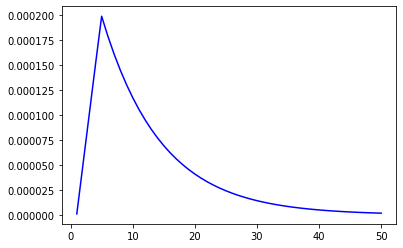

In [66]:
def plot_lr():
    lr = []
    epoch_list = list(np.arange(N_EPOCHS)+1)
    for epoch in range(N_EPOCHS):
        lr.append(lr_schedule_fn(epoch))
    plt.plot(epoch_list, lr,'b-')
    plt.show()

plot_lr()

In [65]:
history = model.fit(
    train_dataset,
    epochs = N_EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_dataset,
    validation_steps = validation_steps,
    callbacks=[lr_callback]
)
#전이학습을 해서그런지 많이 좋당! val_accuracy: 0.9218

Epoch 1/50
148/148 [==============================] - 46s 308ms/step - loss: 3.8787 - accuracy: 0.0277 - val_loss: 3.7388 - val_accuracy: 0.0288
Epoch 2/50
148/148 [==============================] - 45s 301ms/step - loss: 2.1925 - accuracy: 0.5988 - val_loss: 1.0538 - val_accuracy: 0.8964
Epoch 3/50
148/148 [==============================] - 45s 304ms/step - loss: 1.6274 - accuracy: 0.7804 - val_loss: 1.0229 - val_accuracy: 0.8951
Epoch 4/50
148/148 [==============================] - 44s 300ms/step - loss: 1.5377 - accuracy: 0.7983 - val_loss: 1.0535 - val_accuracy: 0.8861
Epoch 5/50
148/148 [==============================] - 45s 303ms/step - loss: 1.4873 - accuracy: 0.8196 - val_loss: 1.0897 - val_accuracy: 0.8690
Epoch 6/50
148/148 [==============================] - 44s 300ms/step - loss: 1.4480 - accuracy: 0.8299 - val_loss: 1.1412 - val_accuracy: 0.8704
Epoch 7/50
148/148 [==============================] - 44s 299ms/step - loss: 1.3971 - accuracy: 0.8463 - val_loss: 1.0774 - val_ac

#DenseNet121을 써보자.

In [71]:
from tensorflow.keras.applications.densenet import DenseNet121

In [73]:
densenet = DenseNet121(weights = 'imagenet', include_top= False, input_shape=(IMG_SIZE,IMG_SIZE,3))
densenet.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________

In [89]:
def MyModel5():
    model = models.Sequential()
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    #덴스, 배치 norm ,랠루 추가했다.
    model.add(Dense(N_CLASS, activation='softmax'))
    return model

In [90]:
model = MyModel5()

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule_fn)

model.compile(optimizer=tf.keras.optimizers.Adam(LR_INIT),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),#레이블 스무딩까지 적용했다.ex) [0.1,0.1,0.1,0.9]식의 labels
              metrics=['accuracy'])

history = model.fit(
    train_dataset,
    epochs = N_EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_dataset,
    validation_steps = validation_steps,
    callbacks=[lr_callback]
)
#제일 잘된다 mobilenetv2에선 0.94를 못 넘었는데 loss도 미세하지만 더 적다.

Epoch 1/50
148/148 [==============================] - 74s 503ms/step - loss: 4.0439 - accuracy: 0.0233 - val_loss: 3.9558 - val_accuracy: 0.0316
Epoch 2/50
148/148 [==============================] - 72s 484ms/step - loss: 2.6049 - accuracy: 0.4495 - val_loss: 1.2324 - val_accuracy: 0.8738
Epoch 3/50
148/148 [==============================] - 71s 482ms/step - loss: 1.6945 - accuracy: 0.7596 - val_loss: 1.0205 - val_accuracy: 0.9246
Epoch 4/50
148/148 [==============================] - 72s 483ms/step - loss: 1.5310 - accuracy: 0.8014 - val_loss: 1.0127 - val_accuracy: 0.9239
Epoch 5/50
148/148 [==============================] - 72s 484ms/step - loss: 1.4418 - accuracy: 0.8287 - val_loss: 1.0456 - val_accuracy: 0.8944
Epoch 6/50
148/148 [==============================] - 72s 484ms/step - loss: 1.3742 - accuracy: 0.8520 - val_loss: 1.0414 - val_accuracy: 0.8923
Epoch 7/50
148/148 [==============================] - 72s 484ms/step - loss: 1.3321 - accuracy: 0.8645 - val_loss: 0.9945 - val_ac

#sample prediction을 치와와로!!

In [91]:
sample_image = Image.open('chihuahua2.jpg')
sample_image = sample_image.resize((224,224))
sample_image = np.array(sample_image)
sample_image = sample_image/255.

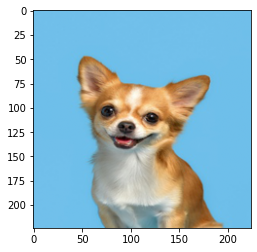

In [92]:
plt.imshow(sample_image)
plt.show()

In [93]:
sample_image = np.reshape(sample_image,(1,224,224,3))

In [94]:
prediction = model.predict(sample_image)
prediction.shape

(1, 37)

In [95]:
pred_class = np.argmax(prediction,axis=-1)
pred_class

array([17])

In [96]:
class_list[int(pred_class)]

'chihuahua'